# Контекст

Для контекста есть смысл получать кварталы буквально на этапе создания проекта, так как контекст не зависит от сценария. Также это поможет избежать большого времени создания слоя городских кварталов с дополнительной информацией.

ВАЖНО: 
- Кварталы контекста получаем для выбранного `project_id`.
- Стараемся работать в `crs` от `boundaries_gdf`.

In [1]:
from blocksnet.config import log_config

log_config.set_logger_level('WARNING')

In [2]:
SCENARIO_ID = 835

In [3]:
from prostor.fetchers import scenarios

PROJECT_ID = scenarios.get_scenario(SCENARIO_ID)['project']['project_id']
PROJECT_ID

120

## Вспомогательный код

Метод `close_gaps` необходим для дружбы геометрий дорог, которые граничат рядом но не соприкасаются на перекрестках точь-в-точь.

Так как мы не хотим цеплять всю библиотеку `momepy` ради одного метода, мы просто честно его скопируем.

In [4]:
import shapely
import geopandas as gpd
import numpy as np

def close_gaps(gdf, tolerance): # taken from momepy
    geom = gdf.geometry.array
    coords = shapely.get_coordinates(geom)
    indices = shapely.get_num_coordinates(geom)

    edges = [0]
    i = 0
    for ind in indices:
        ix = i + ind
        edges.append(ix - 1)
        edges.append(ix)
        i = ix
    edges = edges[:-1]
    points = shapely.points(np.unique(coords[edges], axis=0))

    buffered = shapely.buffer(points, tolerance / 2)

    dissolved = shapely.union_all(buffered)

    exploded = [
        shapely.get_geometry(dissolved, i)
        for i in range(shapely.get_num_geometries(dissolved))
    ]

    centroids = shapely.centroid(exploded)

    snapped = shapely.snap(geom, shapely.union_all(centroids), tolerance)

    return gpd.GeoSeries(snapped, crs=gdf.crs)

## Основная работа

### 1. Получение нужных геометрий

В версии `v1.0.0.a8` в качестве `boundaries_gdf` можно подавать слой из нескольких геометрий.

Поэтому нет необходимости больше объединять их в одну через `union`. 

#### 1.1. Границы территории

Их надо удалить из границ контекста

<Axes: >

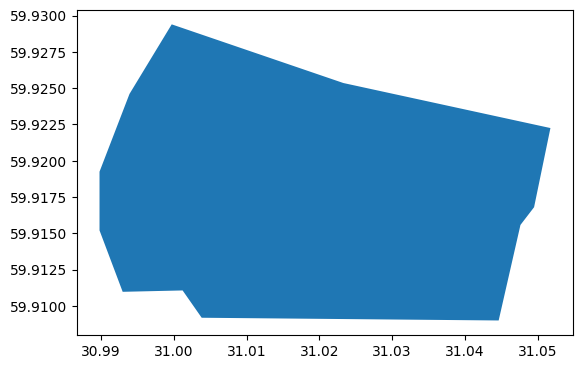

In [5]:
from prostor.fetchers import projects

def get_project_boundaries(project_id : int) -> gpd.GeoDataFrame:
    geometry = projects.get_project_geometry(project_id)
    return gpd.GeoDataFrame(geometry=[geometry], crs=4326)

project_gdf = get_project_boundaries(PROJECT_ID)

project_gdf.plot()

#### 1.2. Границы контекста

<Axes: >

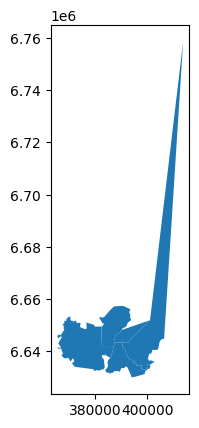

In [6]:
from prostor.fetchers import territories

def get_context_boundaries(project_id : int) -> gpd.GeoDataFrame:
    project = projects.get_project(project_id)
    context_ids = project['properties']['context']
    geometries = [territories.get_territory_geometry(territory_id) for territory_id in context_ids]
    gdf = gpd.GeoDataFrame(geometry=geometries, crs=4326)
    crs = gdf.estimate_utm_crs()
    return gdf.to_crs(crs)

boundaries_gdf = get_context_boundaries(PROJECT_ID)
boundaries_gdf.plot()

In [7]:
boundaries_gdf.crs

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

#### 1.3. Дороги

<Axes: >

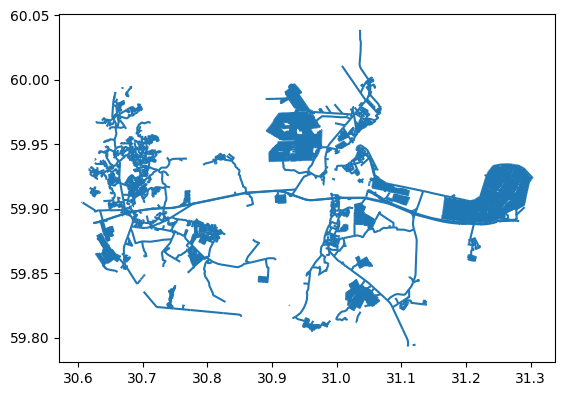

In [8]:
from prostor.fetchers import context

ROADS_POF_ID = 26

roads_gdf = context.get_physical_objects(SCENARIO_ID, physical_object_function_id=ROADS_POF_ID)

roads_gdf.plot()

#### 1.4. Водные объекты

<Axes: >

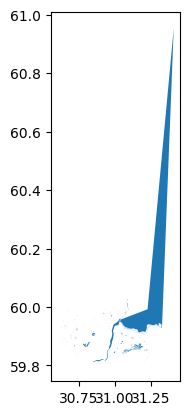

In [9]:
WATER_POF_ID = 4

water_gdf = context.get_physical_objects(SCENARIO_ID, physical_object_function_id=WATER_POF_ID)

water_gdf.plot()

### 2. Генерация слоя городских кварталов

#### 2.1. Удаляем территорию из границ контекста

<Axes: >

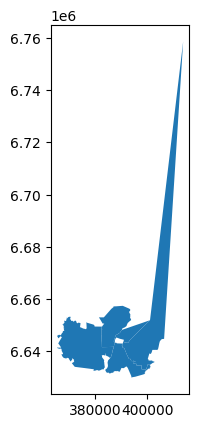

In [10]:
project_gdf = project_gdf.to_crs(boundaries_gdf.crs)

boundaries_gdf = boundaries_gdf.overlay(project_gdf, how='difference')

boundaries_gdf.plot()

#### 2.2. Препроцессинг урбан объектов

In [11]:
from blocksnet.blocks.cutting import preprocess_urban_objects

roads_gdf = roads_gdf.to_crs(boundaries_gdf.crs)
water_gdf = water_gdf.to_crs(boundaries_gdf.crs)

lines_gdf, polygons_gdf = preprocess_urban_objects(roads_gdf, None, water_gdf)

2025-12-19 16:19:08.542 | WARNING  | blocksnet.blocks.cutting.preprocessing.core:preprocess_urban_objects:53 - Creating empty railways


#### 2.3. Нарезка кварталов

- Делаем линиям `close_gaps`, чтобы не было проблем с неточным рисованием.
- Делаем границам буфер `-1`, чтобы всякие линии точно достали. 

2025-12-19 16:19:16.656 | WARNING  | blocksnet.blocks.cutting.processing.schemas:validate_and_preprocess_gdfs:71 - Creating empty buildings


<Axes: >

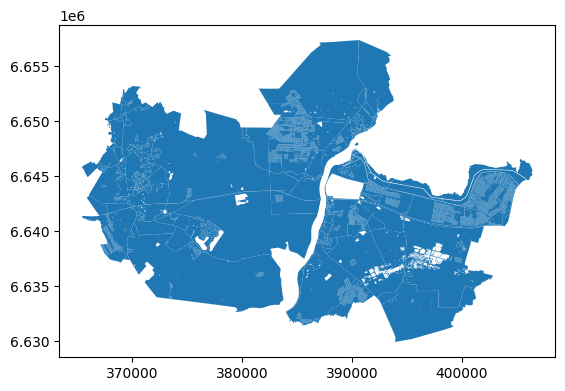

In [12]:
from blocksnet.blocks.cutting import cut_urban_blocks

lines_gdf.geometry = close_gaps(lines_gdf, 1)
boundaries_gdf.geometry = boundaries_gdf.geometry.buffer(-1)

blocks_gdf = cut_urban_blocks(boundaries_gdf, lines_gdf, polygons_gdf)

blocks_gdf.plot()

### 3. Присвоение функциональных назначений

<Axes: >

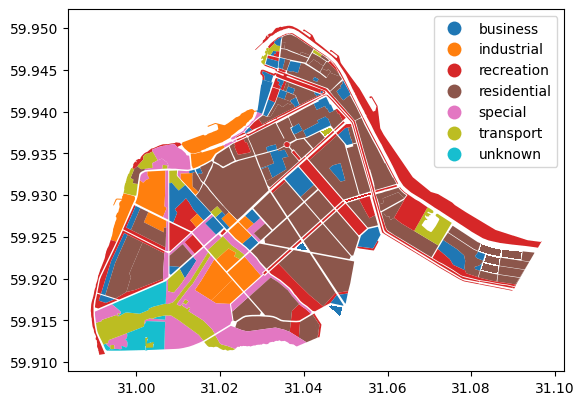

In [13]:
import pandas as pd
from prostor.adapters import adapt_functional_zones

SOURCES_PRIORITY = ['User', 'PZZ', 'OSM']

def _get_best_functional_zones_source(sources_df : pd.DataFrame) -> tuple[int | None, str | None]:
    sources = sources_df['source'].unique()
    for source in SOURCES_PRIORITY:
        if source in sources:
            sources_df = sources_df[sources_df['source'] == source]
            year = sources_df.year.max()
            return int(year), source
    return None, None #FIXME ??? 

def get_context_functional_zones(scenario_id : int) -> gpd.GeoDataFrame:
    sources_df = context.get_functional_zones_sources(scenario_id)
    year, source = _get_best_functional_zones_source(sources_df)
    functional_zones = context.get_functional_zones(scenario_id, year, source)
    return adapt_functional_zones(functional_zones)

functional_zones_gdf = get_context_functional_zones(SCENARIO_ID)

functional_zones_gdf.plot('functional_zone', legend=True)

In [14]:
from blocksnet.blocks.assignment import assign_land_use
from prostor.adapters import LAND_USE_RULES

functional_zones_gdf = functional_zones_gdf.to_crs(blocks_gdf.crs)

land_use_gdf = assign_land_use(blocks_gdf, functional_zones_gdf, LAND_USE_RULES)

land_use_gdf.head()

2025-12-19 16:19:24.540 | WARNING  | blocksnet.blocks.assignment.land_use:_preprocess_functional_zones:17 - Functional zones not in rules: unknown


,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((388726.347 6637020.627, 388713.674 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
1,"POLYGON ((388713.674 6637030.346, 388726.347 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
2,"POLYGON ((374726.595 6642638.322, 374534.487 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
3,"POLYGON ((373713.224 6642499.187, 373726.486 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
4,"POLYGON ((373279.263 6642505.106, 373363.751 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN


<Axes: >

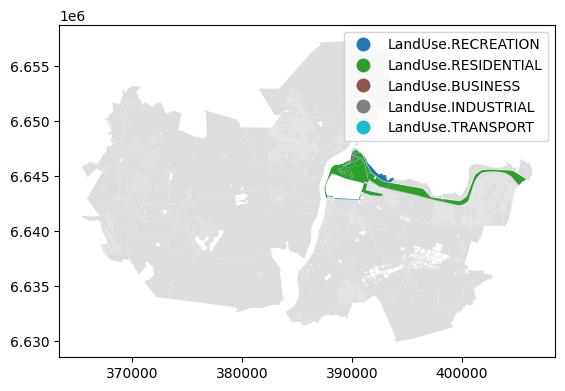

In [15]:
ax = land_use_gdf.plot(color='#ddd')
land_use_gdf.plot('land_use', ax=ax, legend=True)

In [16]:
blocks_gdf = blocks_gdf.join(land_use_gdf.drop(columns=['geometry']))

### 4. Присвоение параметров зданий

In [17]:
from prostor.adapters import adapt_buildings
from blocksnet.preprocessing.imputing import impute_buildings

LIVING_BUILDING_POT_ID = 4

def get_context_buildings(scenario_id : int):
    gdf = context.get_physical_objects(scenario_id, physical_object_type_id=LIVING_BUILDING_POT_ID, centers_only=True)
    gdf = adapt_buildings(gdf.reset_index(drop=True))
    crs = gdf.estimate_utm_crs()
    return impute_buildings(gdf.to_crs(crs)).to_crs(4326)

buildings_gdf = get_context_buildings(SCENARIO_ID)

buildings_gdf.head()

,geometry,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population
0,POINT (30.63852 59.86989),True,1.0,0.0000,0.0000,0.00000,0.00000,1.0
1,POINT (30.64532 59.88113),True,1.0,146.2870,146.2870,131.65830,14.62870,6.0
2,POINT (30.64518 59.87749),True,1.0,95.4810,95.4810,85.93290,9.54810,4.0
3,POINT (30.63923 59.88122),True,1.0,66.1192,66.1192,59.50728,6.61192,2.0
4,POINT (30.64037 59.88421),True,2.0,202.7820,405.5640,365.00760,40.55640,18.0


In [18]:
from blocksnet.blocks.aggregation import aggregate_objects

buildings_agg_gdf,_ = aggregate_objects(blocks_gdf, buildings_gdf.to_crs(blocks_gdf.crs))

buildings_agg_gdf.head()

,geometry,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population,count
0,"POLYGON ((388726.347 6637020.627, 388713.674 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0
1,"POLYGON ((388713.674 6637030.346, 388726.347 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0
2,"POLYGON ((374726.595 6642638.322, 374534.487 6...",61.0,64.0,11433.5786,11578.4709,10446.99381,1131.47709,490.0,61.0
3,"POLYGON ((373713.224 6642499.187, 373726.486 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0
4,"POLYGON ((373279.263 6642505.106, 373363.751 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0


<Axes: >

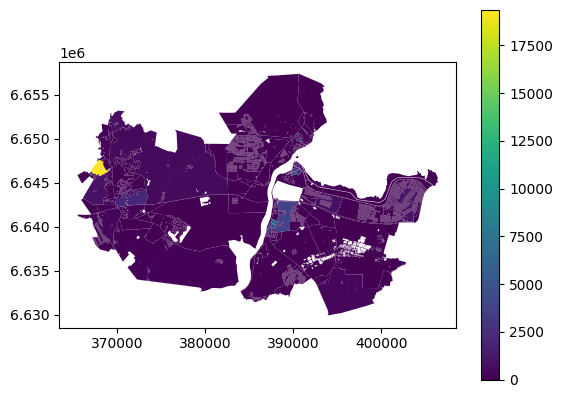

In [19]:
buildings_agg_gdf.plot('population', legend=True)

In [20]:
blocks_gdf = blocks_gdf.join(buildings_agg_gdf.drop(columns=['geometry']).rename(columns={'count': 'count_buildings'}))

### 4. Получение слоев сервисов

In [21]:
service_types_df = pd.read_pickle('data/service_types.pickle')
service_types_df.head()

,capacity_modeled,infrastructure_type,weight,radius_availability_meters,time_availability_minutes,services_per_1000_normative,services_capacity_per_1000_normative,soc_values_ids,blocksnet
service_type_id,,,,,,,,,
1,2000.0,basic,0.2,None,30.0,NaN,150.0,"[1, 8, 18]",park
2,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None
3,NaN,None,NaN,NaN,NaN,NaN,NaN,None,None
4,NaN,None,NaN,NaN,NaN,NaN,NaN,[18],None
5,NaN,comfort,0.5,None,60.0,NaN,64.0,None,beach


Сперва получаем все сервисы по контексту

In [22]:
services_gdf = context.get_services(SCENARIO_ID, centers_only=True)

services_gdf.head(3)

,geometry,service_type,territory_type,name,capacity,is_capacity_real,territories,properties,created_at,updated_at,object_geometry_id,address,osm_id,is_scenario_service,is_scenario_geometry,is_locked
service_id,,,,,,,,,,,,,,,,
589404,POINT (31.02263 59.97478),"{'service_type_id': 79, 'urban_function': {'id...",None,Специальная пожарная часть № 6,45000,False,"[{'id': 1791, 'name': 'городской поселок пос. ...","{'name': 'Специальная пожарная часть № 6', 'os...",2024-10-10T09:31:09.620259Z,2024-10-10T09:31:09.620259Z,586192,None,None,False,False,False
589423,POINT (31.0449 59.93748),"{'service_type_id': 79, 'urban_function': {'id...",None,Пожарная часть № 128,45000,False,"[{'id': 735, 'name': 'город Шлиссельбург'}]","{'name': 'Пожарная часть № 128', 'osm_id': '25...",2024-10-10T09:31:13.972701Z,2024-10-10T09:31:13.972701Z,586211,None,None,False,False,False
589464,POINT (30.98022 59.87249),"{'service_type_id': 79, 'urban_function': {'id...",None,Пожарная часть № 127,45000,False,"[{'id': 733, 'name': 'город Кировск'}]","{'name': 'Пожарная часть № 127', 'osm_id': '38...",2024-10-10T09:31:23.549217Z,2024-10-10T09:31:23.549217Z,586252,None,None,False,False,False


Адаптируем их к инпуту, разбивая `gpd.GeoDataFrame` на `dict[int, gpd.GeoDataFrame]` (ключи = `service_type_id`)

In [23]:
def adapt_service_types(services_gdf : gpd.GeoDataFrame, service_types_df : pd.DataFrame) -> dict[int, gpd.GeoDataFrame]:
    gdfs = {}
    service_types_ids = services_gdf.apply(lambda s : s['service_type']['service_type_id'], axis=1)
    for service_type_id, row in service_types_df.iterrows():
        mask = service_types_ids == service_type_id
        gdf = services_gdf[mask][['geometry','capacity']].copy()
        if gdf.capacity.isna().any(): # если есть пробелы, пробуем заполнять
            fill_value = row['capacity_modeled']
            if fill_value is None:
                fill_value = gdf.capacity.mean()
            gdf.capacity = gdf.capacity.fillna(fill_value)
        gdfs[service_type_id] = gdf
    return gdfs

services_gdfs = adapt_service_types(services_gdf, service_types_df)

services_gdfs.keys()

dict_keys([1, 2, 3, 4, 5, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 132, 133, 134, 135, 143, 144])

Назначаем кварталам

In [24]:
from blocksnet.blocks.aggregation import aggregate_objects

for service_type_id, gdf in services_gdfs.items():
    agg_gdf,_ = aggregate_objects(blocks_gdf, gdf.to_crs(blocks_gdf.crs))
    agg_gdf = agg_gdf.drop(columns=['geometry'])
    columns = {c:f'{c}_{service_type_id}' for c in agg_gdf.columns}
    agg_gdf = agg_gdf.rename(columns=columns)
    blocks_gdf = blocks_gdf.join(agg_gdf)

## Результат

В результате получаем слой со столбцами со всех этапов пайплайна:
- **Геометрии кварталов**.
- **Функциональное зонирование** -- доли `residential`, `recreation` и тд, а также наибольший `land_use` и его доля `share`
- **Параметры зданий** -- `population`, `build_floor_area`, `buildings_count` и тд.
- **Параметры сервисов** -- `capacity_{service_type_id}` и `count_{service_type_id}`

In [25]:
blocks_gdf.to_pickle('./data/context_blocks.pickle')

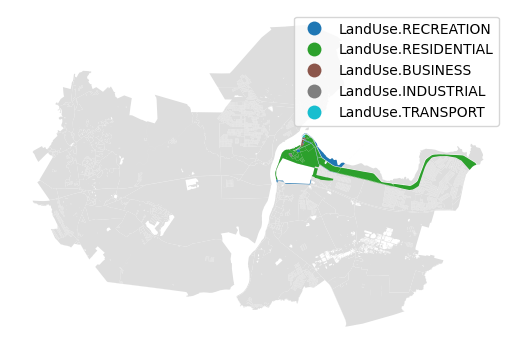

In [26]:
ax = blocks_gdf.plot(color='#ddd')
blocks_gdf.plot(column='land_use', ax=ax, legend=True).set_axis_off()

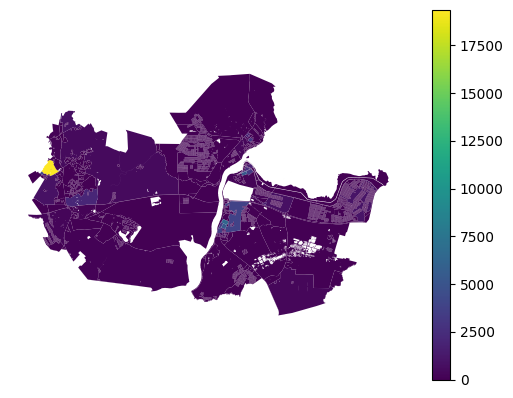

In [27]:
blocks_gdf.plot(column='population', legend=True).set_axis_off()

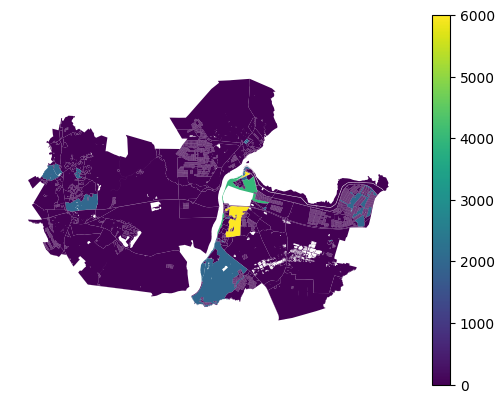

In [28]:
blocks_gdf.plot(column='capacity_1', legend=True).set_axis_off()